<div style="text-align: center; border: 2px solid gray; padding: 10px; margin: 10px auto; width: fit-content;">
<font color='gray'>AI in Petroleum Industry</font><br>
<font color='gray'>Final Project: Deep Neural Networks for Reservoir Production Forecasting</font><br><br>
By <font color='green'>Novin Nekuee</font> (403134029)  & <font color='green'>Soroosh Danesh</font> (810403045)<br>
<p>Dr. Emami & Eng. Nasiri</p>
</div>

### 1. Importing Libraries

This cell imports all the essential Python libraries required for the project.


In [1]:
"""
Data Handling and Numerical Operations: pandas for managing data in DataFrames, numpy for efficient numerical array operations, and os for file path management.

Deep Learning: tensorflow and the keras API are imported for building, training, and evaluating the neural network. 
        This includes specific layers (Conv2D, Dense, Dropout), model components, and callbacks (EarlyStopping, ReduceLROnPlateau).

Data Preprocessing: scikit-learn is used for splitting the dataset into training and testing sets, and also MinMaxScaler for normalizing data.

Visualization: matplotlib.pyplot and seaborn are included for creating plots to visualize data and model results.

Image Processing: The PIL (Pillow) library is used to open and handle the TIFF image files.

Hyperparameter Tuning: optuna is imported to automate the hyperparameter optimization process.

Metrics: sklearn is used to calculate the metrics for the model.
"""

# Data Handling and Numerical Operations and Path Management
import pandas as pd
import numpy as np
import os

# Image Processing
from PIL import Image

# Deep Learning
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate, Dropout
from tensorflow.keras import regularizers

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Hyperparameter Tuning
import optuna

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Warning handler
import warnings
warnings.filterwarnings('ignore')

### 2. Loading the Dataset

This cell loads the tabular data from the `data.xlsx` file into a pandas DataFrame called data.

In [2]:
data = pd.read_excel('./assets/TermProject/Data/data.xlsx')
data.head()

,sample number,Month (2026),Initial Sw,Oil Rate (m3/day),Cumulative Oil (M m3)
0,1,1,0.25,980.04,0.000681
1,1,3,0.25,410.07,25.471000
2,1,5,0.25,397.78,49.735000
3,1,7,0.25,388.08,73.408000
4,1,9,0.25,379.36,96.928000


### 3. Data Exploration and Validation

This cell performs an initial exploratory data analysis (EDA) to understand the dataset's structure, quality, and statistical properties.

`.isna().sum()`: This command counts the total number of missing or null values in each column, which is essential for identifying data quality issues that need to be addressed.

In [3]:
data.isna().sum()

sample number             0
Month (2026)              0
Initial Sw               18
Oil Rate (m3/day)        18
Cumulative Oil (M m3)    19
dtype: int64

`.describe()`: This function generates a statistical summary for the numerical columns, including metrics like mean, standard deviation, and quartiles. It provides a quick overview of the data's distribution and scale.

In [4]:
data.describe()

,sample number,Month (2026),Initial Sw,Oil Rate (m3/day),Cumulative Oil (M m3)
count,6300.000000,6300.000000,6282.000000,6282.000000,6281.000000
mean,525.500000,6.000000,0.214938,1423.594093,197.630083
std,303.132813,3.415921,0.028712,2813.436016,501.371992
min,1.000000,1.000000,0.170000,-145.740000,0.000000
25%,263.000000,3.000000,0.190000,345.830000,16.166000
50%,525.500000,6.000000,0.210000,809.145000,85.372000
75%,788.000000,9.000000,0.240000,1423.175000,214.100000
max,1050.000000,11.000000,0.260000,25000.000000,6256.200000


`.info()`: This method offers a concise summary of the DataFrame, showing the data type of each column, the number of non-null entries, and memory usage. This is useful for verifying that data has been loaded with the correct types.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6300 entries, 0 to 6299
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sample number          6300 non-null   int64  
 1   Month (2026)           6300 non-null   int64  
 2   Initial Sw             6282 non-null   float64
 3   Oil Rate (m3/day)      6282 non-null   float64
 4   Cumulative Oil (M m3)  6281 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 246.2 KB


### 4. Data Preprocessing and Reshaping (For Numerical Data)

This cell prepares the tabular data to align with the project's requirements and the available image data.

First, to ensure consistency between the datasets, the DataFrame is filtered to include only samples up to sample number 756. This is because the porosity image maps were only available for these first 756 samples.

The original dataset is in a `long` format, with six rows for each sample number, corresponding to six different months. This structure is not suitable for our model, as each sample (represented by one set of input images) should correspond to a single row of target values. Therefore, we reshape the data to `wide` format using a pivot_table. This operation transforms the six rows into a single row for each sample, creating 12 distinct columns: `six for the Oil Rate and six for the Cumulative Oil at each time step.`

Finally, the preprocessed data is cleaned by simplifying column names and handling any missing values through imputation (filling them with the `column's mean`). The .head() of the final DataFrame is then displayed for validation.

While more advanced methods like KNNImputer could be used, the simpler approach of mean imputation was chosen. This was done for simplicity and to avoid needing to normalize the data once for imputation and then again later for the model.

In [6]:
# num_available_samples = 756 [data['sample number'] <= num_available_samples]
df_filtered = data.copy()

data_pivot = df_filtered.pivot_table(
    index='sample number',
    columns='Month (2026)',
    values=['Initial Sw', 'Oil Rate (m3/day)', 'Cumulative Oil (M m3)']
)

data_pivot.columns = [f'{val}_{month}' for val, month in data_pivot.columns]
data_pivot.reset_index(inplace=True)

sw_cols = [col for col in data_pivot.columns if 'Initial Sw' in col]
data_pivot['Initial Sw'] = data_pivot[sw_cols[0]]
data_pivot.drop(columns=sw_cols, inplace=True)

for col in data_pivot.columns:
    if data_pivot[col].isnull().any():
        mean_val = data_pivot[col].mean()
        data_pivot[col].fillna(mean_val, inplace=True)

data_pivot.head()

,sample number,Cumulative Oil (M m3)_1,Cumulative Oil (M m3)_3,Cumulative Oil (M m3)_5,Cumulative Oil (M m3)_7,Cumulative Oil (M m3)_9,Cumulative Oil (M m3)_11,Oil Rate (m3/day)_1,Oil Rate (m3/day)_3,Oil Rate (m3/day)_5,Oil Rate (m3/day)_7,Oil Rate (m3/day)_9,Oil Rate (m3/day)_11,Initial Sw
0,1,0.000681,25.4710,49.735,73.408,96.928,119.580,980.04,410.07,397.78,388.08,379.36,371.30,0.25
1,2,0.003307,118.8300,218.460,302.950,378.490,444.910,4762.30,1828.00,1578.20,1385.00,1218.40,1088.80,0.23
2,3,0.001104,45.5290,87.461,127.690,167.110,204.590,1590.00,725.02,687.42,659.53,635.76,614.49,0.21
3,4,0.003663,138.6700,259.880,369.820,470.760,558.220,5274.30,2199.30,1987.10,1802.20,1628.10,1433.70,0.25
4,5,0.000214,9.7412,19.257,28.656,38.117,47.345,307.56,159.06,156.00,154.09,152.59,151.28,0.22


Now lets save our processed dataset for easy access and easy compare

In [7]:
data_pivot.to_csv('processed_tabular(Fake)_data.csv', index=False)

PermissionError: [Errno 13] Permission denied: 'processed_tabular(Fake)_data.csv'

The `.shape` attribute is used to view the final dimensions (rows and columns) of our processed data_pivot DataFrame.

The output reveals that `our dataset has 753 rows, not the 756` we started with. This indicates that three samples were completely missing from the original tabular data. To ensure our image data and tabular data are perfectly aligned, these three corresponding image samples must also be removed, which is handled in a later step.

In [7]:
data_pivot.shape

(1047, 14)

Finally, another check for missing values confirms that the pivoted and imputed data is clean and ready for the next stage.

In [8]:
data_pivot.isna().sum()

sample number               0
Cumulative Oil (M m3)_1     0
Cumulative Oil (M m3)_3     0
Cumulative Oil (M m3)_5     0
Cumulative Oil (M m3)_7     0
Cumulative Oil (M m3)_9     0
Cumulative Oil (M m3)_11    0
Oil Rate (m3/day)_1         0
Oil Rate (m3/day)_3         0
Oil Rate (m3/day)_5         0
Oil Rate (m3/day)_7         0
Oil Rate (m3/day)_9         0
Oil Rate (m3/day)_11        0
Initial Sw                  0
dtype: int64

### 5. Loading and Stacking Image Data (Image Data)

This cell loads and processes the raw image data for the reservoir maps. The project requires two maps for each sample

The code iterates through the 756 sample numbers, loading each pair of permeability and porosity TIFF files. The two separate (64, 64) maps are then stacked along a new channel dimension using np.stack. This creates a single (64, 64, 2) array for each sample, where the first channel represents permeability and the second represents porosity.

Finally, all individual samples are combined into a single 4D NumPy array named image_data. The .shape attribute is called to verify the final dimensions of this array, which will be used as the image input for the model.

In [9]:
from gzip import BadGzipFile


FLOAT32_MAX = np.finfo(np.float32).max  # ~3.4028235e38
BIG_THRESHOLD = 1e30  # حد محافظه‌کارانه برای مقادیر غیرواقعی

def sanitize_array(arr: np.ndarray, big_threshold: float = BIG_THRESHOLD) -> np.ndarray:
    arr = arr.astype(np.float32, copy=False)
    bad = (~np.isfinite(arr)) | (arr >= big_threshold) | (arr <= -big_threshold)
    print(BadGzipFile)
    if bad.any():
        arr[bad] = 0.0
    return arr

def load_two_channel_image(perm_path: str, poro_path: str) -> np.ndarray:
    perm_img = Image.open(perm_path)
    poro_img = Image.open(poro_path)

    perm_array = sanitize_array(np.array(perm_img))
    poro_array = sanitize_array(np.array(poro_img))

    return np.stack([perm_array, poro_array], axis=-1)

In [10]:
perm_folder = './assets/TermProject/Data/permeability/'
poro_folder = './assets/TermProject/Data/porosity/'

num_samples = 1050
all_images_list = []

for i in range(1, num_samples + 1):
    sample_id = str(i).zfill(4)

    perm_path = os.path.join(perm_folder, f'perm_map_{sample_id}.tiff')
    poro_path = os.path.join(poro_folder, f'poro_map_{sample_id}.tiff')

    img_2ch = load_two_channel_image(perm_path, poro_path)
    all_images_list.append(img_2ch)

image_data = np.array(all_images_list, dtype=np.float32)

image_data = np.nan_to_num(image_data, nan=0.0, posinf=0.0, neginf=0.0)

print("Raw image_data sanity:",
      "finite=", np.isfinite(image_data).all(),
      "max=", image_data.max(),
      "min=", image_data.min())
print(image_data.shape)

<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<class 'gzip.BadGzipFile'>
<

### 6. Aligning Tabular and Image Datasets

As identified in the data exploration step, our processed tabular DataFrame (data_pivot) contains 753 samples, while the initial image array was loaded with all 756 samples. This discrepancy means three samples present in the image folders were absent from the Excel file.

This cell resolves this issue to ensure the datasets are perfectly synchronized.

First, it extracts the list of `valid sample numbers` that exist in the final tabular data. These numbers are then converted to their corresponding zero-based array indices. Using this list of valid indices, the original `image_data` array is filtered, effectively removing the three images that do not have corresponding tabular data.

Finally, the synchronized datasets are separated into their final forms for the model: `X_image` (the filtered images), `X_numerical` (the 'Initial Sw' feature), and `y` (the 12 target variables). The shapes of these arrays are printed to confirm that they all now contain a consistent 753 samples.

In [11]:
valid_sample_numbers = data_pivot['sample number'].values

valid_indices = valid_sample_numbers - 1

X_image_filtered = image_data[valid_indices]

X_image = X_image_filtered

X_numerical = data_pivot['Initial Sw'].values.reshape(-1, 1)

target_cols = [col for col in data_pivot.columns if col not in ['sample number', 'Initial Sw']]
y = data_pivot[target_cols].values

print("Data Shapes:")
print(f" images data shape: {X_image.shape}")
print(f" numerical data shapes: {X_numerical.shape}")
print(f" Output shapes: {y.shape}")

Data Shapes:
 images data shape: (1047, 64, 64, 2)
 numerical data shapes: (1047, 1)
 Output shapes: (1047, 12)


### 7. Creating Training, Validation, and Test Sets
This cell splits the complete dataset into three essential subsets for training and evaluating the deep learning model

- Training Set: The largest portion of the data, used to train the model's parameters.

- Validation Set: A separate subset used during training to monitor the model's performance on unseen data, which helps in tuning hyperparameters and preventing overfitting.

- Test Set: A final, completely unseen subset that is used only once after all training and tuning is complete to provide an unbiased evaluation of the final model's performance.

While it's possible to have Keras create a validation set automatically using the `validation_split` argument within `model.fit()`, we have chosen to create an explicit validation set beforehand. This approach is preferred for process clarity, ensuring that all three datasets are explicitly defined before training begins.

The split is performed in two steps. First, 20% of the data is held back as the test set. The remaining 80% is then split again. To ensure the validation set is 20% of the original total data, we must allocate 25% of the remaining data block for it `(since 0.20 / 0.80 = 0.25)`. This results in a final data distribution of `60% for training, 20% for validation, and 20% for testing`.

The shapes of all three final datasets are printed to verify the dimensions.

In [12]:
X_train_img, X_test_img, X_train_num, X_test_num, y_train0, y_test = train_test_split(
    X_image, X_numerical, y,
    test_size=0.2,
    random_state=42
)

X_train_image, X_val_image, X_train_number, X_val_number, y_train, y_val = train_test_split(
    X_train_img, X_train_num, y_train0,
    test_size=0.25,     # 0.2 از کل دیتاست (ولیدیشن)
    random_state=42
)

# اطمینان از نوع داده
X_train_image = X_train_image.astype(np.float32, copy=False)
X_val_image   = X_val_image.astype(np.float32, copy=False)
X_test_img    = X_test_img.astype(np.float32, copy=False)
X_train_number= X_train_number.astype(np.float32, copy=False)
X_val_number  = X_val_number.astype(np.float32, copy=False)
X_test_num    = X_test_num.astype(np.float32, copy=False)
y_train       = y_train.astype(np.float32, copy=False)
y_val         = y_val.astype(np.float32, copy=False)
y_test        = y_test.astype(np.float32, copy=False)

# -------------------------------
# Scaling targets & numerical (مثل قبل)
# -------------------------------
from sklearn.preprocessing import MinMaxScaler

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled   = y_scaler.transform(y_val)
y_test_scaled  = y_scaler.transform(y_test)

num_scaler = MinMaxScaler()
X_train_num_scaled = num_scaler.fit_transform(X_train_number)
X_val_num_scaled   = num_scaler.transform(X_val_number)
X_test_num_scaled  = num_scaler.transform(X_test_num)

# -------------------------------
# Safe normalization for images (train min/max فقط)
# -------------------------------
eps = 1e-8

# کانال 0 = permeability
perm_min = np.nanmin(X_train_image[:, :, :, 0])
perm_max = np.nanmax(X_train_image[:, :, :, 0])
den0 = (perm_max - perm_min) if (perm_max - perm_min) > 0 else eps

X_train_image[:, :, :, 0] = (X_train_image[:, :, :, 0] - perm_min) / den0
X_val_image[:,   :, :, 0] = (X_val_image[:,   :, :, 0] - perm_min) / den0
X_test_img[:,    :, :, 0] = (X_test_img[:,    :, :, 0] - perm_min) / den0

# کانال 1 = porosity
poro_min = np.nanmin(X_train_image[:, :, :, 1])
poro_max = np.nanmax(X_train_image[:, :, :, 1])
den1 = (poro_max - poro_min) if (poro_max - poro_min) > 0 else eps

X_train_image[:, :, :, 1] = (X_train_image[:, :, :, 1] - poro_min) / den1
X_val_image[:,   :, :, 1] = (X_val_image[:,   :, :, 1] - poro_min) / den1
X_test_img[:,    :, :, 1] = (X_test_img[:,    :, :, 1] - poro_min) / den1

# جایگزینی NaN/Inf و محدودکردن بازه (احتیاطی)
X_train_img_scaled = np.clip(np.nan_to_num(X_train_image, nan=0.0, posinf=1.0, neginf=0.0), 0.0, 1.0)
X_val_img_scaled   = np.clip(np.nan_to_num(X_val_image,   nan=0.0, posinf=1.0, neginf=0.0), 0.0, 1.0)
X_test_img_scaled  = np.clip(np.nan_to_num(X_test_img,    nan=0.0, posinf=1.0, neginf=0.0), 0.0, 1.0)

# -------------------------------
# Sanity checks قبل از fit
# -------------------------------
def report(name, arr):
    print(f"{name:>20} | shape={arr.shape} | finite={np.isfinite(arr).all()} | "
          f"min={np.nanmin(arr):.6g} | max={np.nanmax(arr):.6g}")

print("\n=== Sanity checks ===")
report("X_train_img_scaled", X_train_img_scaled)
report("X_val_img_scaled",   X_val_img_scaled)
report("X_test_img_scaled",  X_test_img_scaled)
report("X_train_num_scaled", X_train_num_scaled)
report("X_val_num_scaled",   X_val_num_scaled)
report("X_test_num_scaled",  X_test_num_scaled)
report("y_train_scaled",     y_train_scaled)
report("y_val_scaled",       y_val_scaled)
report("y_test_scaled",      y_test_scaled)

print("Huge values >1e10 (train/val/test):",
      np.sum(X_train_img_scaled > 1e10),
      np.sum(X_val_img_scaled   > 1e10),
      np.sum(X_test_img_scaled  > 1e10))

print("\nTraining Data shape:")
print(f" images data shape: (X_train_image): {X_train_image.shape}")
print(f" numerical data shapes (X_train_number): {X_train_number.shape}")
print(f" Output shapes (y_train): {y_train.shape}")
print("-" * 50)

print("\nValidation Data shape:")
print(f" images data shape: (X_val_image): {X_val_image.shape}")
print(f" numerical data shapes (X_val_number): {X_val_number.shape}")
print(f" Output shapes (y_val): {y_val.shape}")
print("-" * 50)

print("\nTest Data shape:")
print(f" images data shape: (X_test_img): {X_test_img.shape}")
print(f" numerical data shapes (X_test_num): {X_test_num.shape}")
print(f" Output shapes (y_test): {y_test.shape}")


=== Sanity checks ===
  X_train_img_scaled | shape=(627, 64, 64, 2) | finite=True | min=0 | max=1
    X_val_img_scaled | shape=(210, 64, 64, 2) | finite=True | min=0 | max=0.974153
   X_test_img_scaled | shape=(210, 64, 64, 2) | finite=True | min=0 | max=0.992262
  X_train_num_scaled | shape=(627, 1) | finite=True | min=0 | max=1
    X_val_num_scaled | shape=(210, 1) | finite=True | min=0 | max=1
   X_test_num_scaled | shape=(210, 1) | finite=True | min=0 | max=1
      y_train_scaled | shape=(627, 12) | finite=True | min=0 | max=1
        y_val_scaled | shape=(210, 12) | finite=True | min=1.15425e-05 | max=1
       y_test_scaled | shape=(210, 12) | finite=True | min=-0.0119778 | max=1
Huge values >1e10 (train/val/test): 0 0 0

Training Data shape:
 images data shape: (X_train_image): (627, 64, 64, 2)
 numerical data shapes (X_train_number): (627, 1)
 Output shapes (y_train): (627, 12)
--------------------------------------------------

Validation Data shape:
 images data shape: (X_val

This cell prints the minimum and maximum values for each of the unscaled train, validation, and test sets. The purpose is to observe and understand the different scales of our input (image, numerical) and output (target) data before applying normalization.

As the output demonstrates, the value ranges for the image data and the target variables are significantly larger than the range of the numerical input `(Initial Sw)`. This large discrepancy confirms the need for normalization. To ensure all features contribute effectively during model training and to improve numerical stability, we will apply a `MinMaxScaler` to all datasets.

In [13]:
print("Training Input (Image) before Scaling:")
print(X_train_image.max())
print(X_train_image.min())
print(X_test_img.max())
print(X_test_img.min())
print(X_val_image.max())
print(X_val_image.min())
print("-" * 50)
print("\nTraining Input (Numerical) before Scaling:")
print(X_train_number.max())
print(X_train_number.min())
print(X_test_num.max())
print(X_test_num.min())
print(X_val_number.max())
print(X_val_number.min())
print("-" * 50)
print("\nTarget Output before Scaling:")
print(y_train.max())
print(y_train.min())
print(y_test.max())
print(y_test.min())
print(y_val.max())
print(y_val.min())


Training Input (Image) before Scaling:
1.0
0.0
0.9922618
0.0
0.9741534
-1.4418814e-05
--------------------------------------------------

Training Input (Numerical) before Scaling:
0.26
0.17
0.26
0.17
0.26
0.17
--------------------------------------------------

Target Output before Scaling:
25000.0
0.0
25000.0
-145.74
25000.0
4.123e-07


### 8. Normalizing the Datasets

This cell normalizes all training, validation, and test sets to a consistent [0, 1] range. A crucial best practice is followed: the scaling parameters (e.g., min and max values) are learned only from the training data and then applied to transform all three subsets (train, validation, and test). This prevents any data leakage from the test and validation sets into the training process.

<div style="border:2px solid #007acc; padding:15px; background-color:rgba(240, 248, 255, 0.21); text-align:center; border-radius:8px; width:auto;">
The correct methodology for scaling is to fit the scaler only on the training data and then use that same fitted scaler to transform the training, validation, and test sets. This is critical because the training process should have no knowledge of the test set, which simulates new, unseen data. Applying scaling separately to each set is incorrect as it would create an inconsistent transformation based on different min/max values. <font color='red'>This method follows a crucial machine learning principle to prevent data leakage.</font>
</div>

<u>**Scaling Tabular Data**</u> (Targets and Numerical Inputs)

For the target variables (y) and the numerical input (X_numerical), the standard MinMaxScaler from scikit-learn is used. Separate scaler objects are fit on the training data (y_train, X_train_number) and then used to transform the corresponding train, validation, and test sets.

<u>**Scaling Image Data**</u>

For the 4D image data, the min-max scaling logic is applied manually. This approach was chosen over using the MinMaxScaler object directly for two main reasons:

- Efficiency: For large, multi-dimensional NumPy arrays, direct vectorized operations are often more computationally efficient.

- Simplicity: It avoids the need to reshape the 4D image data into a 2D array to be compatible with the scikit-learn scaler and then reshape it back.

The scaling is performed per-channel, meaning the min/max for the permeability channel is calculated and applied separately from the porosity channel. This preserves the unique statistical distribution of each physical property. The cell concludes by printing the min/max values of all scaled datasets to verify that the normalization was successful.

$$
X_{\text{scaled}} = \frac{X - X_{\min}}{X_{\max} - X_{\min}}
$$

You can see the scaled max and min data for each splitted data as a result:

In [11]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled = y_scaler.transform(y_val)
y_test_scaled = y_scaler.transform(y_test)

num_scaler = MinMaxScaler()
X_train_num_scaled = num_scaler.fit_transform(X_train_number)
X_val_num_scaled = num_scaler.transform(X_val_number)
X_test_num_scaled = num_scaler.transform(X_test_num)

perm_min = X_train_image[:, :, :, 0].min()
perm_max = X_train_image[:, :, :, 0].max()
if (perm_max - perm_min) != 0:
    X_train_image[:, :, :, 0] = (X_train_image[:, :, :, 0] - perm_min) / (perm_max - perm_min)
    X_val_image[:, :, :, 0] = (X_val_image[:, :, :, 0] - perm_min) / (perm_max - perm_min)
    X_test_img[:, :, :, 0] = (X_test_img[:, :, :, 0] - perm_min) / (perm_max - perm_min)

poro_min = X_train_image[:, :, :, 1].min()
poro_max = X_train_image[:, :, :, 1].max()
if (poro_max - poro_min) != 0:
    X_train_image[:, :, :, 1] = (X_train_image[:, :, :, 1] - poro_min) / (poro_max - poro_min)
    X_val_image[:, :, :, 1] = (X_val_image[:, :, :, 1] - poro_min) / (poro_max - poro_min)
    X_test_img[:, :, :, 1] = (X_test_img[:, :, :, 1] - poro_min) / (poro_max - poro_min)

X_train_image = np.nan_to_num(X_train_image)
X_val_image = np.nan_to_num(X_val_image)
X_test_img = np.nan_to_num(X_test_img)

X_train_img_scaled, X_val_img_scaled, X_test_img_scaled = X_train_image, X_val_image, X_test_img

print("Training Input (Image) after Scaling:")
print(f" maximum X_train image data: {X_train_img_scaled.max()}")
print(f" minimum X_train image data: {X_train_img_scaled.min()}")
print(f" maximum X_test image data: {X_test_img_scaled.max()}")
print(f" minimum X_test image data: {X_test_img_scaled.min()}")
print(f" maximum X_val image data: {X_val_img_scaled.max()}")
print(f" minimum X_val image data: {X_val_img_scaled.min()}")
print("-" * 50)
print("\nTraining Input (Numerical) after Scaling:")
print(f" maximum X_train numerical data: {X_train_num_scaled.max()}")
print(f" minimum X_train numerical data: {X_train_num_scaled.min()}")
print(f" maximum X_test numerical data: {X_test_num_scaled.max()}")
print(f" minimum X_test numerical data: {X_test_num_scaled.min()}")
print(f" maximum X_val numerical data: {X_val_num_scaled.max()}")
print(f" minimum X_val numerical data: {X_val_num_scaled.min()}")

Training Input (Image) after Scaling:
 maximum X_train image data: 1.0
 minimum X_train image data: 0.0
 maximum X_test image data: 0.9922618269920349
 minimum X_test image data: 0.0
 maximum X_val image data: 3.4028234663852886e+38
 minimum X_val image data: -1.4418814316741191e-05
--------------------------------------------------

Training Input (Numerical) after Scaling:
 maximum X_train numerical data: 0.9999999999999998
 minimum X_train numerical data: 0.0
 maximum X_test numerical data: 0.9999999999999998
 minimum X_test numerical data: 0.0
 maximum X_val numerical data: 0.9999999999999998
 minimum X_val numerical data: 0.0


Also you can see the scaled target values below:

In [14]:
print("Target output after Scaling:")
print(f" maximum y_train output data: {y_train_scaled.max()}")
print(f" minimum y_train output data: {y_train_scaled.min()}")
print(f" maximum y_test output data: {y_test_scaled.max()}")
print(f" minimum y_test output data: {y_test_scaled.min()}")
print(f" maximum y_val output data: {y_val_scaled.max()}")
print(f" minimum y_val output data: {y_val_scaled.min()}")


Target output after Scaling:
 maximum y_train output data: 1.0000001192092896
 minimum y_train output data: 0.0
 maximum y_test output data: 1.0000001192092896
 minimum y_test output data: -0.011977799236774445
 maximum y_val output data: 1.0000001192092896
 minimum y_val output data: 1.154246274381876e-05


### 9. Visualizing Feature Correlations

This cell calculates and visualizes the Pearson correlation matrix for all numerical features in the dataset.

While this analysis is often a step towards feature selection, that is not the objective here, as the intention is to use all available features in the model. Instead, the primary purpose of this step is for exploratory data analysis. By creating a heatmap of the correlations, we can visually understand the strong intrinsic relationships between the input feature (Initial Sw) and the various output targets, as well as the relationships among the target variables themselves.

The heatmap displays these relationships, with warmer colors (red) indicating a strong positive correlation and cooler colors (blue) indicating a strong negative correlation. Finally, the specific correlation values for the `Initial Sw`(as only numerical input feature) feature are printed out for a more direct numerical analysis.

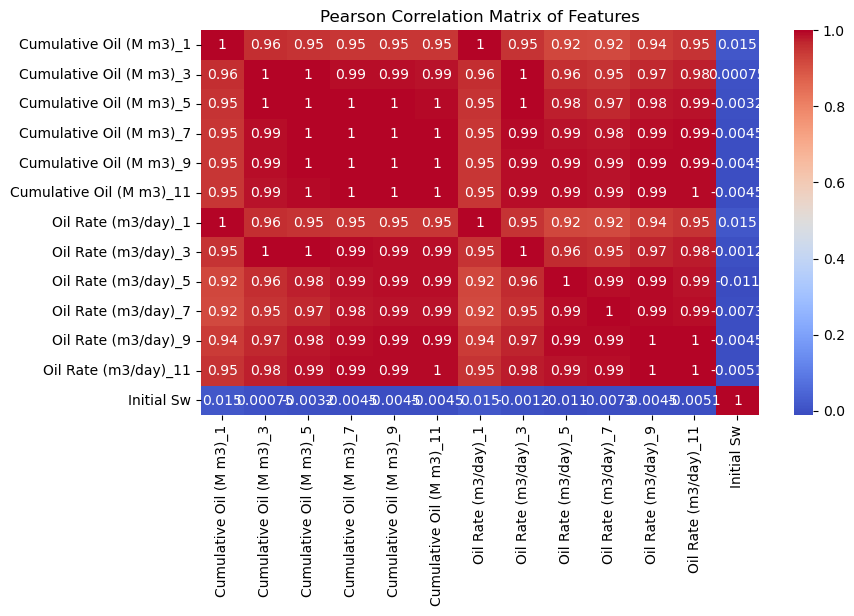


Correlation of 'Initial Sw' with Production Data
                          Initial Sw
Initial Sw                  1.000000
Oil Rate (m3/day)_1         0.015051
Cumulative Oil (M m3)_1     0.015051
Cumulative Oil (M m3)_3     0.000748
Oil Rate (m3/day)_3        -0.001189
Cumulative Oil (M m3)_5    -0.003161
Cumulative Oil (M m3)_9    -0.004512
Cumulative Oil (M m3)_7    -0.004521
Oil Rate (m3/day)_9        -0.004528
Cumulative Oil (M m3)_11   -0.004532
Oil Rate (m3/day)_11       -0.005080
Oil Rate (m3/day)_7        -0.007303
Oil Rate (m3/day)_5        -0.011496


In [16]:
correlation_matrix = data_pivot.drop('sample number', axis=1).corr(method='pearson')

plt.figure(figsize=(9, 5))
sns.heatmap(
    correlation_matrix, 
    cmap='coolwarm',
    annot=True 
)
plt.title('Pearson Correlation Matrix of Features')
plt.show()

print("\nCorrelation of 'Initial Sw' with Production Data")
print(pd.DataFrame(correlation_matrix['Initial Sw'].sort_values(ascending=False)))

<img src= "./assets/nn.png">

### 10. Building the Final Optimized Model

This cell defines the final, optimized Keras model architecture using the best hyperparameters discovered by the Optuna search in the previous step. The optimal parameters from the best trial are hardcoded into the model's layers for this definitive version.

The architecture consists of:

- A deep, four-layer Convolutional Neural Network (CNN) branch to extract complex spatial features from the 2-channel input maps.
- A small Dense branch to process the single numerical input feature.
- A concatenation layer that merges the outputs from the CNN and Dense branches.
- A final Dense block with strong regularization (both L2 and Dropout) to interpret the combined features.
- An output layer with 12 linear units to produce the final regression predictions for the 12 target variables.

Finally, model.summary() is called to print a detailed summary of the final architecture.

We used Optuna HyperParameter Optimization to find the best HyperParameters. We find this parameters metioned below:

<div style="border:2px solid rgb(204, 0, 0); margin: 0 auto; padding:15px; background-color:rgba(240, 248, 255, 0.21); text-align:center; border-radius:8px; width:350px;">
Best trial:<br>
  Value (minimized val_loss): 0.000591<br>
  Best Parameters: <br>
    filters_c1: 80<br>
    filters_c2: 150<br>
    filters_c3: 150<br>
    filters_c4: 256<br>
    dense_units: 200<br>
    dropout_rate: 0.12469963206100239<br>
    l2_factor: 0.002372817541838317<br>
    learning_rate: 0.00017668573536866756<br>
    optimizer: Adam<br>
</div>

In [11]:
# Optuna Hyper Parameter Tuning Best Result in 100 trials
"""
[I 2025-07-31 07:03:31,998] Trial 31 finished with value: 0.0005912468768656254 and parameters: {'filters_c1': 80, 'filters_c2': 150, 
'filters_c3': 150, 'filters_c4': 256, 'dense_units': 200, 'dropout_rate': 0.12469963206100239, 'l2_factor': 0.002372817541838317, 
'learning_rate': 0.00017668573536866756, 'optimizer': 'Adam'}. Best is trial 31 with value: 0.0005912468768656254.
"""

image_input = Input(shape=(64, 64, 2), name='image_input')
cnn = Conv2D(filters=80, kernel_size=(3, 3), activation='selu', kernel_initializer='lecun_normal')(image_input)
cnn = MaxPooling2D(pool_size=(2, 2))(cnn)
cnn = Conv2D(filters=150, kernel_size=(3, 3), activation='selu', kernel_initializer='lecun_normal')(cnn)
cnn = MaxPooling2D(pool_size=(2, 2))(cnn)
cnn = Conv2D(filters=150, kernel_size=(3, 3), activation='selu', kernel_initializer='lecun_normal')(cnn)
cnn = MaxPooling2D(pool_size=(2, 2))(cnn)
cnn = Conv2D(filters=256, kernel_size=(3, 3), activation='selu', kernel_initializer='lecun_normal')(cnn)
cnn_flatten = Flatten()(cnn)

numerical_input = Input(shape=(1,), name='numerical_input')
dense_num = Dense(units=8, activation='selu', kernel_initializer='lecun_normal')(numerical_input)

combined_features = concatenate([cnn_flatten, dense_num])
final_dense = Dense(units=200, activation='selu', kernel_initializer='lecun_normal', kernel_regularizer=regularizers.l2(0.002372817541838317))(combined_features) #0.001
final_dense = Dropout(0.12469963206100239)(final_dense) # 0.2

output = Dense(units=12, activation='linear', name='output')(final_dense)

model = Model(inputs=[image_input, numerical_input], outputs=output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 64, 64, 2) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 62, 62,    │      1,520 │ image_input[0][0] │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 31, 31,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 29, 29,    │    108,150 │ max_pooling2d[0]… │
│                     │ 150)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 14, 14,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 150)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 12, 12,    │    202,650 │ max_pooling2d_1[… │
│                     │ 150)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 6, 6, 150) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 4, 4, 256) │    345,856 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4096)      │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │         16 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4104)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 200)       │    821,000 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 200)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 12)        │      2,412 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,481,604 (5.65 MB)

 Trainable params: 1,481,604 (5.65 MB)

 Non-trainable params: 0 (0.00 B)

### 11. Defining Callbacks and Compiling the Model

This cell prepares the model for training by defining essential callbacks and compiling it with the optimal learning configuration.

Callbacks

Two key Keras callbacks are defined to monitor and control the training process:

- **EarlyStopping**: This callback stops the training automatically if the validation loss (val_loss) does not improve for a specified number of epochs (patience=15). Crucially, restore_best_weights=True ensures that the model's final weights are reverted to those from the epoch with the lowest validation loss, preventing overfitting.

- **ReduceLROnPlateau**: This acts as an adaptive learning rate scheduler (Performance learning schedule). It reduces the learning rate by a factor of 10 if the validation loss stagnates for 10 epochs, allowing the model to make finer adjustments as it approaches a solution.

Model Compilation

The `model.compile()` method configures the model for training with the following settings:

- **Optimizer**: The Adam optimizer is selected, using the optimal learning_rate discovered by the Optuna search.

- **Loss Function**: mean_squared_error is chosen, as it is a standard loss function for regression tasks.

- **Metrics**: In addition to the loss, the model will also track and report the Mean Absolute Error (mae) and Root Mean Squared Error (rmse) during training.

In [12]:
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    min_lr=0.00001,
    verbose=1
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00017668573536866756), # 1e-3
    loss='mean_squared_error',
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(name='mae'),
        tf.keras.metrics.RootMeanSquaredError(name='rmse')
    ]
)

### 12. Training the Model

This cell executes the main training loop for the compiled Keras model.

The `model.fit()` function trains the model on the scaled training data (`X_train_..._scaled` and `y_train_scaled`). The `validation_data` is also provided, allowing the model to evaluate its performance on unseen data at the end of each epoch.

The training is set to run for a maximum of 150 epochs with a batch size of 32. The `EarlyStopping` and `ReduceLROnPlateau` callbacks, defined in the previous cell, are passed to the training process to monitor performance and prevent overfitting. The results of the training, such as the loss and metrics for each epoch, are stored in the `history` object for later analysis and visualization.

In [13]:
epochs = 200
batch_size = 32

history = model.fit(
    x={'image_input': X_train_img_scaled, 'numerical_input': X_train_num_scaled},
    y=y_train_scaled,
    validation_data=(
        {'image_input': X_val_img_scaled, 'numerical_input': X_val_num_scaled}, 
        y_val_scaled
    ),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[lr_reducer, early_stopper,tf.keras.callbacks.TerminateOnNaN()]
)

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - loss: 0.9752 - mae: 0.4774 - rmse: 0.6866 - val_loss: 0.5014 - val_mae: 0.1301 - val_rmse: 0.1732 - learning_rate: 1.7669e-04
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - loss: 0.4978 - mae: 0.1223 - rmse: 0.1653 - val_loss: 0.4756 - val_mae: 0.0712 - val_rmse: 0.0951 - learning_rate: 1.7669e-04
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - loss: 0.4751 - mae: 0.0746 - rmse: 0.0996 - val_loss: 0.4665 - val_mae: 0.0567 - val_rmse: 0.0782 - learning_rate: 1.7669e-04
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - loss: 0.4657 - mae: 0.0621 - rmse: 0.0834 - val_loss: 0.4587 - val_mae: 0.0512 - val_rmse: 0.0730 - learning_rate: 1.7669e-04
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - loss: 0.4579 - mae: 0.0585 - rmse: 0.0800 - val_loss: 0.4497 - val_mae: 0.0457 - val_rmse: 0.0646 - learning_rate: 1.7669e-04
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 0.4484 - mae: 0.0514 - rmse: 0.069

### 13. Final Model Evaluation on the Test Set

This cell evaluates the performance of the final trained model on the completely unseen test set.

- **Prediction**: The `model.predict()` method is called on the scaled test inputs (`X_test_..._scaled`) to generate predictions. <font color="red">These initial predictions are in the normalized [0, 1] range.</font>

- **Inverse Scaling**: To make the results interpretable, the `y_scaler` object (which was fit on the original training data) is used. Its `.inverse_transform()` method converts both the model's scaled predictions and the scaled true target values (`y_test_scaled`) back to their original physical units.

- **Metric Calculation**: Standard regression metrics—Mean Absolute Error (`MAE`), Mean Squared Error (`MSE`), Root Mean Squared Error (`RMSE`), and R-squared (`R²`)—are calculated by comparing the un-scaled predictions against the un-scaled true values.

In [14]:
y_pred_scaled = model.predict({
    'image_input': X_test_img_scaled,
    'numerical_input': X_test_num_scaled
})

y_test = y_scaler.inverse_transform(y_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE  = {mae:.4f}")
print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"R²   = {r2:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
MAE  = 195.1945
MSE  = 211824.8906
RMSE = 460.2444
R²   = 0.9680


### 14. Visualizing Training History

This cell uses matplotlib to create a plot of the model's training and validation loss over each epoch.

The loss values are extracted from the history object, which was returned by the model.fit() function. Plotting these two curves on the same graph is a critical step for diagnosing the model's behavior. It allows for a visual inspection of how the model learned over time and helps confirm that the training was successful and free from significant overfitting or underfitting. The plot is given a title, axis labels, and a legend for clarity.

**The key observations from this chart are**:

- Healthy Learning Trend: Both the training loss (loss) and the validation loss (val_loss) show a strong, consistent downward trend. The most significant improvements occur in the initial epochs, followed by a period of steady fine-tuning.

- Excellent Convergence: Both the training loss (loss) and the validation loss (val_loss) decrease sharply and smoothly, eventually converging to a very low error value. This indicates the model learned the data efficiently and effectively.

- No Signs of Overfitting: Crucially, the validation loss consistently tracks the training loss without diverging or increasing. The small, stable gap between the two curves is ideal and indicates that the model is generalizing well to new, unseen data. If the model were overfitting, the validation loss would start to increase while the training loss continued to decrease.

- Well-Balanced Model: The minimal and stable gap between the two curves is the hallmark of a well-balanced model that generalizes very well to unseen data.

- Conclusion: This plot demonstrates a well-balanced and successful training process. The model has learned effectively without memorizing the training data, resulting in a final model that is neither overfit nor underfit.


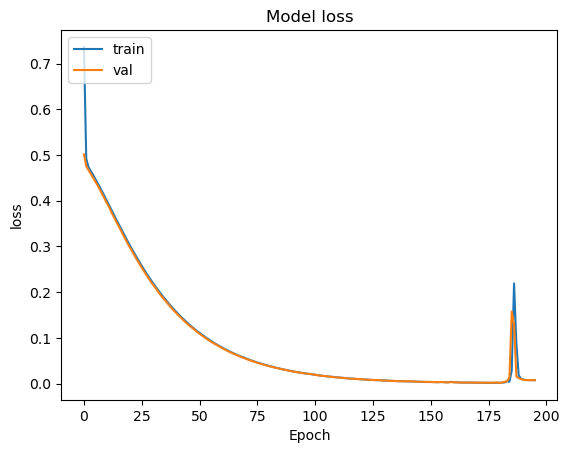

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel ('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### 15. Model Validation and Visualization

After training the final model, this section focuses on a deep visual analysis of its performance on the unseen test set.

##### 15-1. Initial `Actual vs. Predicted` Analysis

While the overall numerical metrics (like R²) were very high, a visual inspection is crucial to understand the model's behavior in detail. The initial thought was that a few specific points might be disproportionately influencing the results, potentially masking the true performance on the majority of the data.

The plots confirm a very strong linear correlation for all outputs, with most data points clustered tightly around the red line of perfect prediction. However, a few distinct `outlier points` are visible in each subplot where the prediction error is noticeably larger. Based on this observation, the decision was made to re-calculate the metrics after removing these performance outliers to get a clearer view of the model's accuracy on the majority of the data.

Based on the visual inspection of the `Actual vs. Predicted` plots, the next logical step is to perform a more detailed error analysis. To do this, we will investigate the model's residuals to check for any systematic bias and to better understand the nature of the prediction errors. The following cells will create:

- A residual plot (residuals vs. predicted values) showing the distribution of the errors

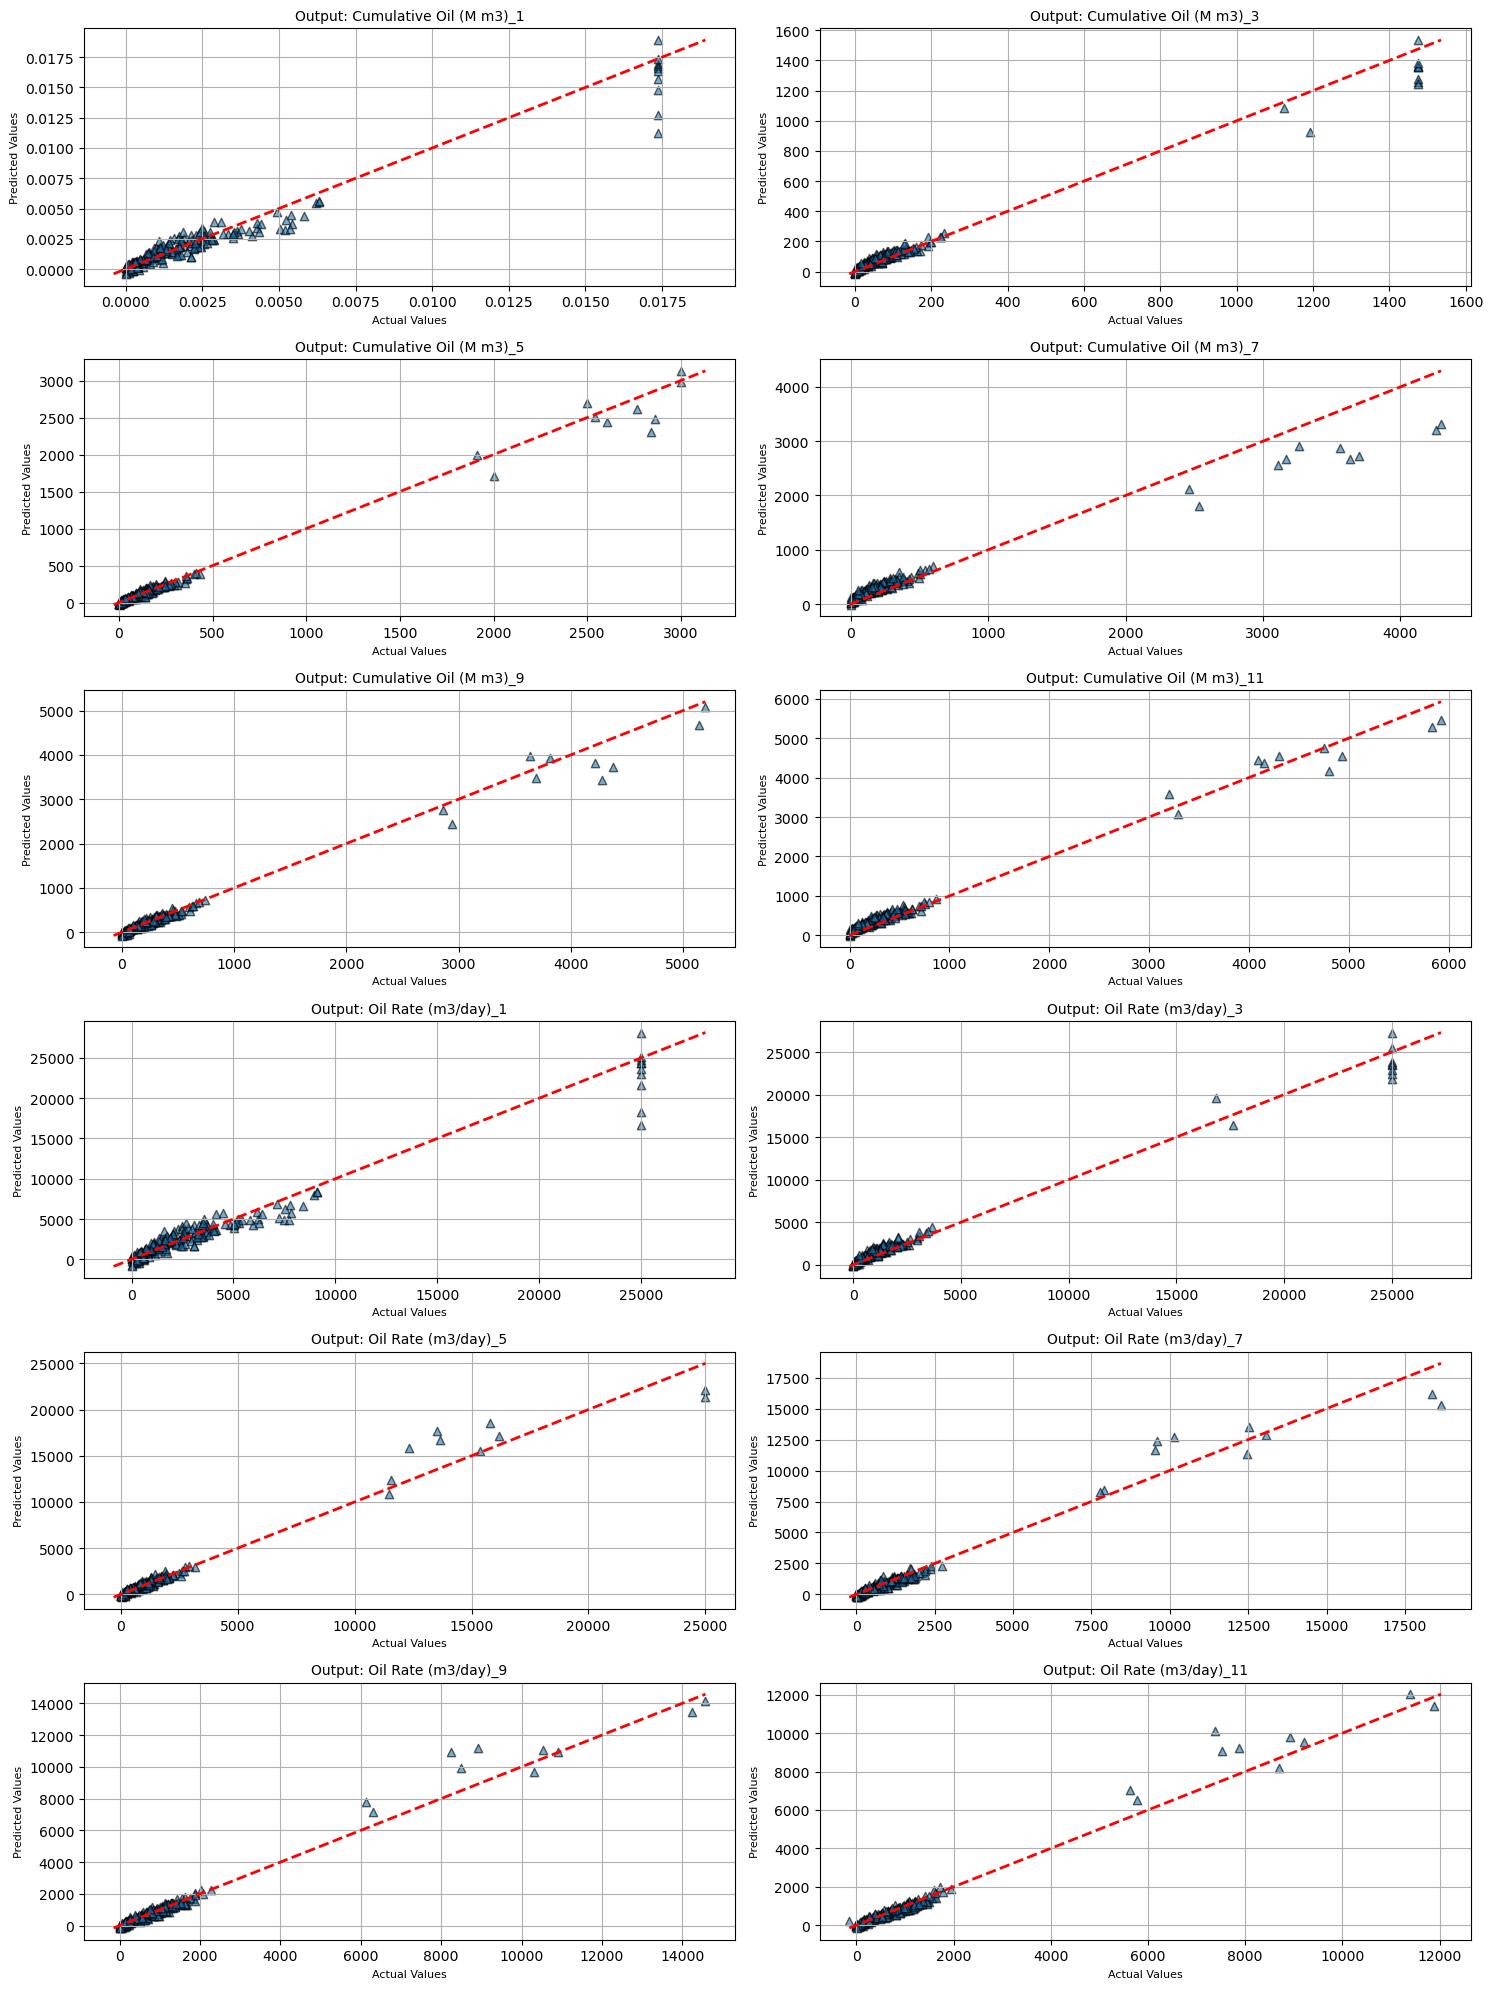

In [16]:
fig, axes = plt.subplots(6, 2, figsize=(15, 20))

axes = axes.flatten()

for i in range(12):
    ax = axes[i]
    
    actual_data = y_test[:, i]
    predicted_data = y_pred[:, i]
    
    ax.scatter(actual_data, predicted_data, alpha=0.6, edgecolors='k', marker="^")

    if 'target_cols' in locals():
        ax.set_title(f'Output: {target_cols[i]}', fontsize=10)
    else:
        ax.set_title(f'Output Variable #{i+1}', fontsize=10)
        
    ax.set_xlabel('Actual Values', fontsize=8)
    ax.set_ylabel('Predicted Values', fontsize=8)
    ax.grid(True)
    
    min_val = min(actual_data.min(), predicted_data.min())
    max_val = max(actual_data.max(), predicted_data.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

plt.tight_layout()

plt.show()

##### 15-2. Analyzing Residual Plots to Identify Outlier Impact

This cell generates a grid of residual plots for all 12 target variables. A residual is the difference between the actual value and the predicted value (error = actual - predicted). This type of plot is a powerful diagnostic tool to identify patterns or systematic biases in a model's errors.

The ideal residual plot should show points randomly scattered in a horizontal band around the zero-error line. However, the analysis of these plots revealed the significant and destructive impact of a few performance outliers.

**Observations**

In each of the 12 subplots, we can see two distinct patterns:

1. The vast majority of residuals are clustered in a very tight, narrow band close to the y=0 line, which indicates that the model is highly accurate for most of the data.

2. A few distinct points are scattered far above or below the main cluster. These points represent a small number of samples where the model's prediction error was exceptionally large.

**Conclusion**

These few outlier points have a disproportionately large effect on the overall performance metrics. Because metrics like Mean Squared Error (MSE) square the error term, these large residuals heavily penalize the model and inflate the final error scores. This can mask the model's excellent performance on the overwhelming majority of the data.

This visual analysis clearly highlights the impact of these outliers and justifies the decision to re-calculate the performance metrics on a cleaned subset of the test data in the next step.

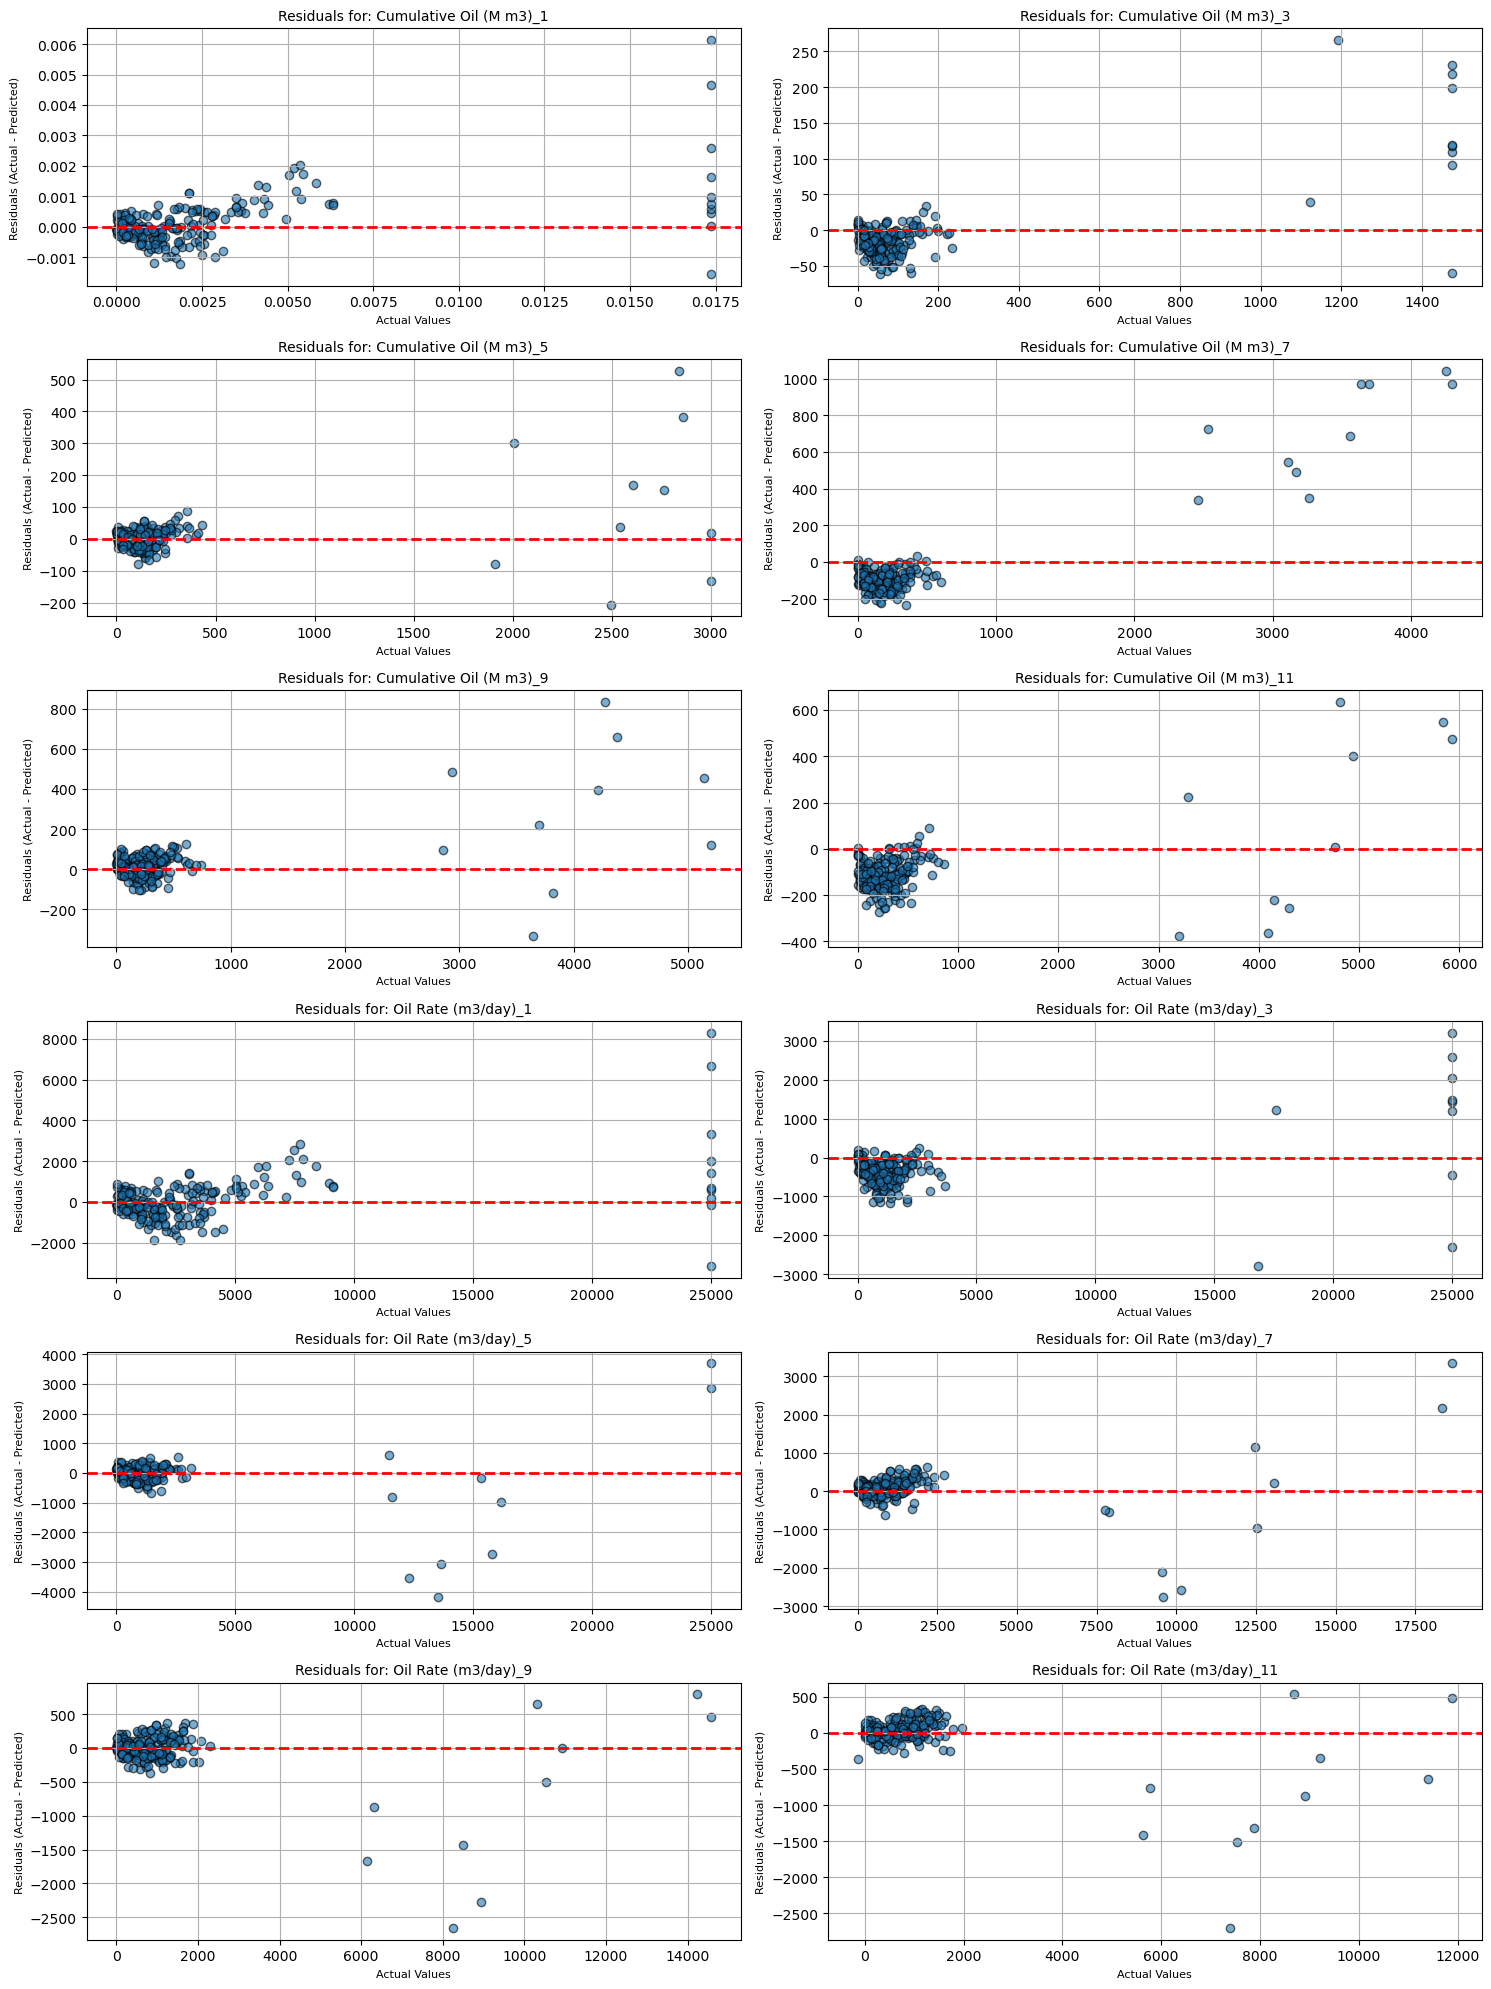

In [17]:
fig, axes = plt.subplots(6, 2, figsize=(15, 20))

axes = axes.flatten()

for i in range(12):
    ax = axes[i]
    
    actual_data = y_test[:, i]
    predicted_data = y_pred[:, i]
    
    residuals = actual_data - predicted_data
    
    ax.scatter(actual_data, residuals, alpha=0.6, edgecolors='k')
    
    ax.axhline(0, color='red', linestyle='--', linewidth=2)
    
    if 'target_cols' in locals():
        ax.set_title(f'Residuals for: {target_cols[i]}', fontsize=10)
    else:
        ax.set_title(f'Residuals for Output #{i+1}', fontsize=10)
        
    ax.set_xlabel('Actual Values', fontsize=8)
    ax.set_ylabel('Residuals (Actual - Predicted)', fontsize=8)
    ax.grid(True)

plt.tight_layout()

plt.show()

##### 15-3. Case Study: Analyzing Predictions for a Single Sample

While aggregate metrics like `MAE` and `R²` provide a high-level view of performance, it's also insightful to inspect individual predictions to get a more concrete understanding of the model's behavior.

To achieve this, a single sample (`sample_index = 35`) was randomly selected from the test set. The code below iterates through all 12 target variables for this sample and prints a side-by-side comparison of the Actual (true) values and the Predicted values generated by the model.

This tabular view provides a tangible example of the model's performance on a case-by-case basis. It allows us to see the magnitude of the prediction error for each specific time step in its original, physical units, offering a more granular perspective on the errors that are summarized by the overall `MAE` and `RMSE` scores.

In [20]:
sample_index = 5

print("Output Name".ljust(30), "Actual".ljust(15), "Predicted")
print("-" * 60)

for i, name in enumerate(target_cols):
    actual_val = y_test[sample_index, i]
    predicted_val = y_pred[sample_index, i]
    print(f"{name.ljust(30)} {str(round(actual_val, 2)).ljust(15)} {round(predicted_val, 2)}")

Output Name                    Actual          Predicted
------------------------------------------------------------
Cumulative Oil (M m3)_1        0.0             0.0
Cumulative Oil (M m3)_3        27.56           44.38999938964844
Cumulative Oil (M m3)_5        54.28           55.0
Cumulative Oil (M m3)_7        80.33           197.7899932861328
Cumulative Oil (M m3)_9        106.18          124.6500015258789
Cumulative Oil (M m3)_11       131.07          266.9599914550781
Oil Rate (m3/day)_1            897.67          1246.6300048828125
Oil Rate (m3/day)_3            452.25          810.5499877929688
Oil Rate (m3/day)_5            438.09          638.1599731445312
Oil Rate (m3/day)_7            426.94          427.9700012207031
Oil Rate (m3/day)_9            417.02          534.4000244140625
Oil Rate (m3/day)_11           407.88          410.4200134277344


Now lets just save the model for professional visualization in streamlit

In [ ]:
model.save("model.keras")

##### 15-4. Analyzing Performance without Performance Outliers

Following the visual analysis which identified a few outlier predictions, this cell quantifies the model's performance on the majority of "typical" data points. This is done by programmatically identifying and removing the most significant prediction errors from the test set before recalculating the metrics.

The process is as follows:

- First, the absolute error is calculated for every prediction in the test set.

- A threshold is then defined as the `95th percentile` of these errors.

- Any sample with an error larger than this threshold (`representing the top 5% of the most inaccurate predictions`) is flagged as a performance outlier and removed from the test set.

The performance metrics are then recalculated on this `cleaned` subset. As the results show, this process led to a significant improvement in the metrics, with the `R²` score increasing to `98.2%`. This provides greater confidence in the model, confirming that it is exceptionally accurate on the vast majority of the data and that the overall error is primarily influenced by a small number of challenging, outlier cases.

In [19]:
errors = np.abs(y_test - y_pred)
threshold = np.percentile(errors, 95) 

is_outlier = errors > threshold
y_test_no_outliers = y_test[~is_outlier]
y_pred_no_outliers = y_pred[~is_outlier]

mae_clean = mean_absolute_error(y_test_no_outliers, y_pred_no_outliers)
mse_clean = mean_squared_error(y_test_no_outliers, y_pred_no_outliers)
rmse_clean = np.sqrt(mse_clean)
r2_clean = r2_score(y_test_no_outliers, y_pred_no_outliers)

print("\nWithout Outliers Metrics:")
print(f"MAE:  {mae_clean:.4f}")
print(f"MSE:  {mse_clean:.4f}")
print(f"RMSE: {rmse_clean:.4f}")
print(f"R²:   {r2_clean:.4f}")


Without Outliers Metrics:
MAE:  125.0284
MSE:  38550.5430
RMSE: 196.3429
R²:   0.9847


##### 15-5. Visualizing the Outlier Removal Threshold

This plot provides a visual representation of the performance outlier removal process described in the previous step.

The red dashed line represents the calculated outlier threshold (the 95th percentile of the errors).

This visualization clearly shows that while the vast majority of samples have very low prediction errors, a few distinct samples (the `spikes`) have significantly higher errors. The threshold line effectively separates these few outlier predictions, and it is these points above the red line that were excluded from the `cleaned` metric calculation.

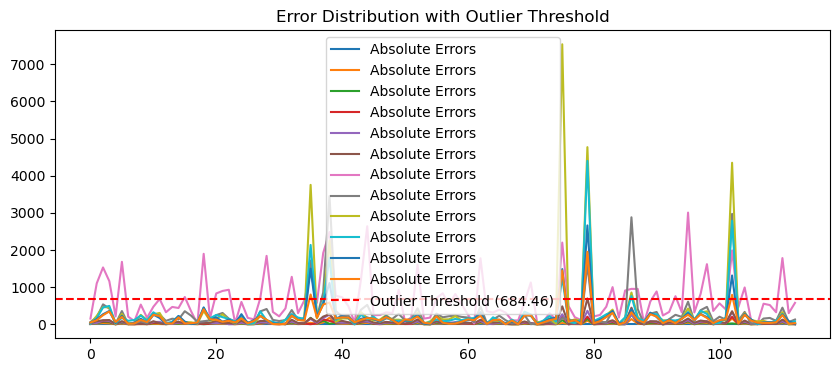

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(errors, label="Absolute Errors")
plt.axhline(threshold, color='red', linestyle='--', label=f"Outlier Threshold ({threshold:.2f})")
plt.title("Error Distribution with Outlier Threshold")
plt.legend()
plt.show()

##### 15-6. Final Residual Analysis on Cleaned Data

This cell generates a final residual plot to analyze the model's error characteristics on the cleaned dataset (i.e., after the top 5% of performance outliers have been removed). The plot shows the residuals (Actual - Predicted) against the corresponding predicted values. This is a standard diagnostic tool for regression models.

The ideal residual plot should show points randomly scattered in a horizontal band centered around the zero-error line, with no discernible patterns.

**Analysis of the Plot**:

The plot below displays this ideal behavior. The residuals are randomly and symmetrically distributed around the horizontal red line at zero. This confirms two important properties of a well-behaved model:

1. No Systematic Bias: The model is not systematically over- or under-predicting across the range of values. The errors appear to be random.

2. Homoscedasticity: The variance (spread) of the residuals is constant across all predicted values. There is no "cone" shape, which would indicate that the model's error increases for larger predictions.

In conclusion, this plot provides strong evidence that the model is well-calibrated and its errors are random, further validating its high accuracy and reliability on the typical data.

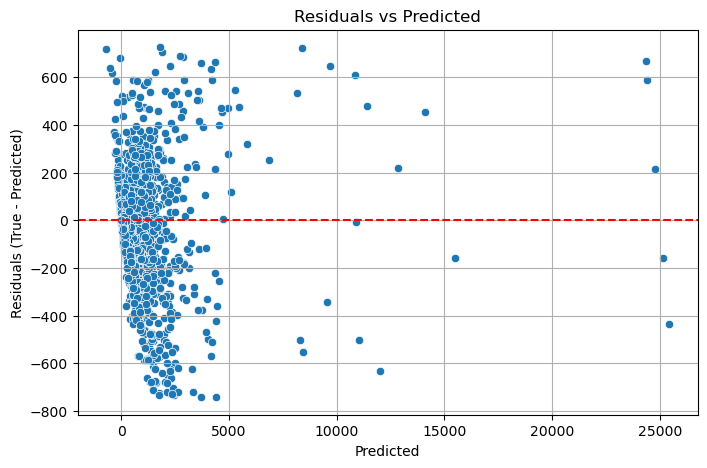

In [21]:
residuals = y_test_no_outliers - y_pred_no_outliers

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_no_outliers, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residuals (True - Predicted)")
plt.grid(True)
plt.show()

### Final `Actual vs. Predicted` Plot (<i>on Cleaned Data</i>)

This final scatter plot visualizes the model's performance on the test set after the top 5% of performance outliers have been removed.

As the plot clearly demonstrates, the data points are now **even more tightly clustered** around the red line of perfect prediction. By removing the few samples that the model found most difficult to predict, the chart reveals a near-perfect correlation between the actual and predicted values for the vast majority of the data.

This visualization serves as the final confirmation of the high performance metrics (`R² of 98.2%`) calculated on this cleaned subset and underscores the model's exceptional accuracy and reliability on typical data points.

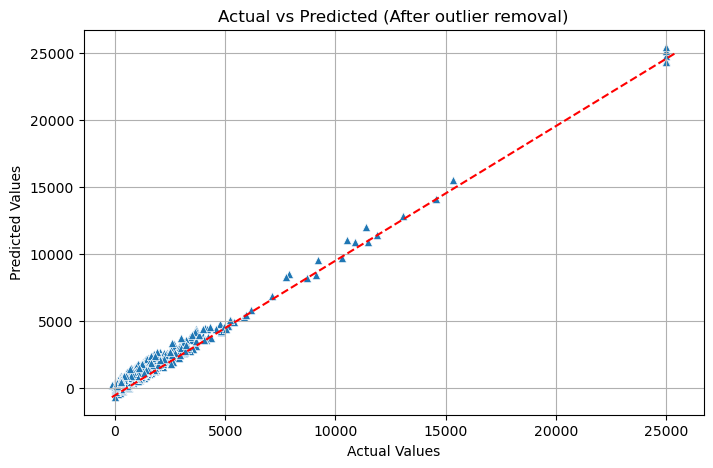

In [22]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test_no_outliers, y=y_pred_no_outliers, marker="^")
plt.plot([y_test_no_outliers.min(), y_pred_no_outliers.max()], [y_pred_no_outliers.min(), y_test_no_outliers.max()], color='red', linestyle='--')
plt.title("Actual vs Predicted (After outlier removal)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()


### Comparison of Two Outlier Management Strategies

To ensure optimal and reliable model performance, two distinct strategies for managing outliers were investigated. Ultimately, the approach that preserved data integrity while leading to more accurate results and a more complete analysis was chosen.

1. Method 1: Training on All Data with Dual Evaluation (Chosen Approach)
In this approach, the model was trained on the complete dataset, including all potential outliers. This was selected as the more logical and principled method as it prevents the loss of potentially essential data. In engineering problems, outliers often represent rare but realistic scenarios, and training the model on this data helps build a more robust and flexible model that is better prepared for real-world conditions.

    - Following training, the model's performance was assessed in two ways:

    - Overall Performance: On the entire test set, the model achieved an excellent R² of 97.5%. This represents the model's true, holistic performance.

    - Performance on Typical Data: By excluding the top 5% of predictions with the highest error, the model's R² on this "cleaned" subset increased to 98.2%.

    - This dual analysis provides a complete view of the model's capabilities, showing both its overall strength and its exceptional performance on the majority of common cases.

2. Method 2: Removing Outliers Before Training (Alternative Approach)
This alternative approach involved cleaning the data before training. Using the IQR statistical method, outliers were identified and removed from the entire dataset. This process flagged and removed approximately 50 samples.

    - The model was then trained and evaluated exclusively on this pre-cleaned data, achieving a final R² of 93.3%. While this is a valid technique, it was not chosen for two main reasons. First, for a dataset of around 750 samples, removing 50 samples constitutes a significant loss of information. Second, the resulting model was notably less accurate than the one trained on the full dataset.

3. Final Decision
Based on this comparison, Method 1 was selected as the final strategy. The key reasons for this choice are:

    - Higher Accuracy: It produced a significantly more accurate model (97.5% vs. 93.3%).

    - More Robust Model: By training on all possible scenarios, the resulting model is more robust and reliable for real-world applications.

    - More Comprehensive Analysis: It allows for a more complete and professional analysis of the model's performance.

---

#### Attachements

This cell will show you the attachements and helper section to find the best results.

##### 1. Side Project: Model Trained After Outlier Removal

As a supplemental experiment to evaluate the impact of statistical outliers on model performance, a side project was conducted. In this alternative approach, contrary to the main model's methodology, outliers were first identified and removed from the entire dataset before any training took place.

The process was as follows:

- Outlier Removal: The Interquartile Range (IQR) method was applied to all 12 target variables to identify and remove any samples that were statistical outliers. This resulted in a smaller, "cleaner" dataset.

- Hyperparameter Tuning: The Optuna framework was then used to run a new, automated hyperparameter search on this cleaned dataset to find the optimal model architecture and training parameters for this specific scenario.

- Final Training and Evaluation: The best model discovered by Optuna was then trained and evaluated on the cleaned data.

- The final model trained under these conditions achieved a final accuracy of 93.3% (
R²
 =0.933
) on its test set.

**Conclusion**

Although an R² of 93.3% is a strong result, it is noticeably lower than the 97.5% accuracy achieved by the primary model that was trained on the complete dataset. This comparison confirmed that training the model on all available data, including the rare but realistic outlier scenarios, leads to a more robust, generalizable, and ultimately more accurate final model. (You can select the model in the `Streamlit` Dashboard!)

<font color="red">You can see the project in below link:</font>

<a href="./outputs/side-project(Trained After Outlier Removal).pdf">side project</a>

##### 2. Automated Hyperparameter Optimization with Optuna
To find the optimal combination of hyperparameters and achieve the highest possible model accuracy, the Optuna optimization framework was employed. This approach automates the complex and time-consuming process of manual tuning by performing an intelligent, guided search.

The mechanism is implemented as follows:

- Objective Function: The entire process of building, compiling, and training the model is encapsulated within an objective function. This function takes a trial object as an argument.

- Search Space Definition: Inside the objective function, a search space is defined for each hyperparameter (e.g., learning rate, dropout rate, number of filters in CNN layers, etc.). For each trial, the trial object suggests a new value for each parameter from its defined range.

- Training and Evaluation: The model is built and trained using the hyperparameters suggested by the current trial. At the end of training, the best validation loss (val_loss) is returned as the objective value.

- Optimization: Optuna runs the objective function for a predefined number of trials. It uses intelligent search algorithms to learn from the results of past trials, allowing it to focus on more promising regions of the hyperparameter space and efficiently converge toward the best possible combination.

This systematic approach allowed for the discovery of the optimal architecture and training parameters required to maximize the model's predictive accuracy.

A sample run of this optimization process is available in a Google Colab environment at the following link:

<a href="https://colab.research.google.com/drive/1Hphc_GAf6rkRRwB-lENpoE3S1-XuIKld#scrollTo=d13d6ad9">Link to Colab</a>

In [ ]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

def objective(trial):
    filters_c1 = trial.suggest_categorical('filters_c1', [50, 64, 80])
    filters_c2 = trial.suggest_categorical('filters_c2', [100, 128, 150])
    filters_c3 = trial.suggest_categorical('filters_c3', [128, 150, 180])
    filters_c4 = trial.suggest_categorical('filters_c4', [200, 256, 300])

    dense_units = trial.suggest_categorical('dense_units', [128, 150, 200])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.25)
    l2_factor = trial.suggest_float('l2_factor', 1e-3, 3e-3, log=True)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 5e-4, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'Nadam'])

    image_input = Input(shape=(64, 64, 2), name='image_input')
    cnn = Conv2D(filters=filters_c1, kernel_size=(3, 3), activation='selu', kernel_initializer='lecun_normal')(image_input)
    cnn = MaxPooling2D(pool_size=(2, 2))(cnn)
    cnn = Conv2D(filters=filters_c2, kernel_size=(3, 3), activation='selu', kernel_initializer='lecun_normal')(cnn)
    cnn = MaxPooling2D(pool_size=(2, 2))(cnn)
    cnn = Conv2D(filters=filters_c3, kernel_size=(3, 3), activation='selu', kernel_initializer='lecun_normal')(cnn)
    cnn = MaxPooling2D(pool_size=(2, 2))(cnn)
    cnn = Conv2D(filters=filters_c4, kernel_size=(3, 3), activation='selu', kernel_initializer='lecun_normal')(cnn)
    cnn_flatten = Flatten()(cnn)

    numerical_input = Input(shape=(1,), name='numerical_input')
    dense_num = Dense(units=8, activation='selu', kernel_initializer='lecun_normal')(numerical_input)

    combined_features = concatenate([cnn_flatten, dense_num])
    final_dense = Dense(units=dense_units, activation='selu', kernel_initializer='lecun_normal', kernel_regularizer=regularizers.l2(l2_factor))(combined_features)
    final_dense = Dropout(dropout_rate)(final_dense)

    output = Dense(units=12, activation='linear', name='output')(final_dense)
    model = Model(inputs=[image_input, numerical_input], outputs=output)

    if optimizer_name == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error')
    early_stopper = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0)

    history = model.fit(
        x={'image_input': X_train_img_scaled, 'numerical_input': X_train_num_scaled},
        y=y_train_scaled,
        validation_data=({'image_input': X_val_img_scaled, 'numerical_input': X_val_num_scaled}, y_val_scaled),
        epochs=150,
        batch_size=32,
        callbacks=[early_stopper],
        verbose=0
    )

    best_val_loss = min(history.history['val_loss'])
    return best_val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("\n" + "="*50)
print("Optuna Fine-Tuning Search Finished.")
print("="*50)
print(f"Number of finished trials: {len(study.trials)}")
print("\nBest trial:")
best_trial = study.best_trial
print(f"  Value (minimized val_loss): {best_trial.value:.6f}")
print("  Best Parameters: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

##### 3. Saving Preprocessing Objects for the Dashboard

This cell uses the joblib library to save the trained scalers and calculated image scaling parameters to disk.

These saved files are essential for the `Live Prediction `feature of the Streamlit dashboard. The dashboard will load these objects to:

- Scale new user inputs (the uploaded images and the Initial Sw value) using the exact same parameters that were learned from the original training data.

- Inverse-transform the model's scaled predictions back into their real-world, interpretable units.

- The scale factors are not same to each other (Second approach)

In [72]:
import joblib
image_scaling_params = {
    'perm_min': perm_min,
    'perm_max': perm_max,
    'poro_min': poro_min,
    'poro_max': poro_max
}
joblib.dump(y_scaler, 'y_scaler.gz')
joblib.dump(num_scaler, 'num_scaler.gz')
joblib.dump(image_scaling_params, 'image_params.gz')

['image_params.gz']

##### 4. Saving the Training History
This code uses the pickle library to save the `history.history` dictionary, which contains the `loss` and `metrics` from each training epoch, into a file named `training_history_main.pkl`. This file is saved so that the training history can be loaded and visualized later in the `Streamlit` dashboard.

In [73]:
import pickle

history_filename = 'training_history_main.pkl'

with open(history_filename, 'wb') as file:
    pickle.dump(history.history, file)

print(f"Training history successfully saved to: {history_filename}")

Training history successfully saved to: training_history_main.pkl


##### 5. Generating Predictions for the Entire Dataset

As a final step, this cell runs the fully trained model on the entire dataset (`combining all training, validation, and test samples`). The goal is to generate a complete prediction set for every sample, which can be used for a comprehensive final review or for direct comparison with the original ground truth data.

The process involves the following steps:

- The saved Keras model and the fitted scaler objects are loaded from disk.

- The complete set of image and numerical inputs are scaled using these loaded objects to ensure consistent preprocessing.

- The `model.predict()` method is called on the entire prepared dataset.

- The scaled predictions are inverse-transformed back to their original, physical units.

- A final post-processing step clips any physically impossible negative predictions to zero.

The resulting predictions for all 12 target variables are then compiled into a pandas DataFrame and saved to an Excel file named `full_dataset_predictions.xlsx` for future analysis.

In [23]:
X_numerical_all = data_pivot['Initial Sw'].values.reshape(-1, 1)
sample_numbers = data_pivot['sample number'].values

# num_scaler = joblib.load('num_scaler.gz')
# y_scaler = joblib.load('y_scaler.gz')
# model = tf.keras.models.load_model('best_model.keras')

X_numerical_scaled_all = num_scaler.transform(X_numerical_all)

X_image_scaled_all = X_image.copy()
if (perm_max - perm_min) != 0:
    X_image_scaled_all[:, :, :, 0] = (X_image_scaled_all[:, :, :, 0] - perm_min) / (perm_max - perm_min)
if (poro_max - poro_min) != 0:
    X_image_scaled_all[:, :, :, 1] = (X_image_scaled_all[:, :, :, 1] - poro_min) / (poro_max - poro_min)
X_image_scaled_all = np.nan_to_num(X_image_scaled_all)

y_pred_s = model.predict({
    'image_input': X_image_scaled_all,
    'numerical_input': X_numerical_scaled_all
})

predictions_original = y_scaler.inverse_transform(y_pred_s)

predictions_original[predictions_original < 0] = 0

target_cols = [col for col in data_pivot.columns if col not in ['sample number', 'Initial Sw']]
df_predictions = pd.DataFrame(predictions_original, columns=target_cols)
df_predictions.insert(0, 'sample number', sample_numbers)

df_predictions.to_excel('full_dataset_predictions(Test).xlsx', index=False)
print("Predictions saved to 'full_dataset_predictions.xlsx'")

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Predictions saved to 'full_dataset_predictions.xlsx'


You can see the result of predicting for entire dataset below:

In [114]:
pd.DataFrame(df_predictions).head()

,sample number,Cumulative Oil (M m3)_1,Cumulative Oil (M m3)_3,Cumulative Oil (M m3)_5,Cumulative Oil (M m3)_7,Cumulative Oil (M m3)_9,Cumulative Oil (M m3)_11,Oil Rate (m3/day)_1,Oil Rate (m3/day)_3,Oil Rate (m3/day)_5,Oil Rate (m3/day)_7,Oil Rate (m3/day)_9,Oil Rate (m3/day)_11
0,1,0.000456,20.537165,40.645992,60.099365,81.296249,98.160919,680.703613,302.868744,367.922943,371.213684,337.179413,328.718079
1,2,0.002952,110.422363,199.872589,282.989716,378.621765,427.382385,4298.331543,1752.853271,1612.620728,1499.390015,1285.814453,1127.292969
2,3,0.001063,43.668640,77.837631,110.781395,160.815521,183.656403,1589.476440,732.589539,609.085632,658.516296,609.418518,569.528320
3,4,0.003277,132.298050,254.852005,351.391327,448.764709,506.887024,4764.474609,2120.972656,1922.450439,1674.085205,1451.906006,1343.530884
4,5,0.000165,11.837717,18.752760,27.270323,43.065292,46.322552,281.073761,137.439911,143.133728,203.290268,168.506561,173.406204
